# Задание для курсовой работы

## Тема курсовой:
### "Анализ пременимости методов обработки данных чековых транзакций и их сравнение"

Для начала определим цель обработки: мы хотим получить систему рекомендаций клиентам на основе данных транзакций.

Этапы работы:

* 1. EDA
* 2. на основе EDA найти пременимые методы FE и найти наиболее подходящий
* 3. Построить рекомендательную систему
* 4. Провести сравненеие полученового результата с результатом AutoML(что бы получить метрику качества применения методов)

Файл с датасетом - dataset.csv

Датасет - информация о покупках клиентов:

**Дата** - время покупки

**Транзакция** - уникальный номер покупки

**Клиент** - уникальный номер клиента

**Товар** - уникальный номер товара

**Количество** - количество купленных товаров

**Сумма** - цена покупки этого товара

### 1. Импорт библиотек

In [106]:
#Ваш код
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import copy
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, dbscan
from sklearn.model_selection import train_test_split
import copy



%matplotlib inline

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

# увеличим дефолтный размер графиков
from pylab import rcParams
import seaborn as sns

rcParams["figure.figsize"] = 10, 6
sns.set_style("whitegrid", {'axes.grid' : True})

### 2. Загрузка данных

In [2]:
#Ваш код
df = pd.read_csv(r'./dataset.csv', delimiter=";", header=0, names= ['date','activity', 'customer', 'goods', 'amount', 'price'])   
df

,date,activity,customer,goods,amount,price
0,03.05.2020 21:43,954,1,2874.0,1.0,8150.0
1,20.11.2020 20:46,13796,1,3586.0,1.0,3930.0
2,08.12.2020 16:28,14431,1,4942.0,1.0,2860.0
3,03.05.2020 21:15,951,2,2812.0,1.0,4895.0
4,20.05.2020 16:46,3352,2,5025.0,1.0,840.0
...,...,...,...,...,...,...
48298,06.07.2021 15:00,25398,11049,1211.0,1.0,20500.0
48299,06.07.2021 15:13,25399,11049,3034.0,1.0,21950.0
48300,06.07.2021 15:02,25412,11050,443.0,1.0,1490.0
48301,06.07.2021 15:02,25412,11050,2789.0,1.0,9450.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48303 entries, 0 to 48302
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      48303 non-null  object 
 1   activity  48303 non-null  int64  
 2   customer  48303 non-null  int64  
 3   goods     48273 non-null  float64
 4   amount    48303 non-null  float64
 5   price     48303 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df.amount = df.amount.astype('int')

## 3. Очистка данных

**Преобразование данных, обработка пропусков, удаление дубликатов**

### Пропуски:

Количество пропусков: 30


<AxesSubplot:>

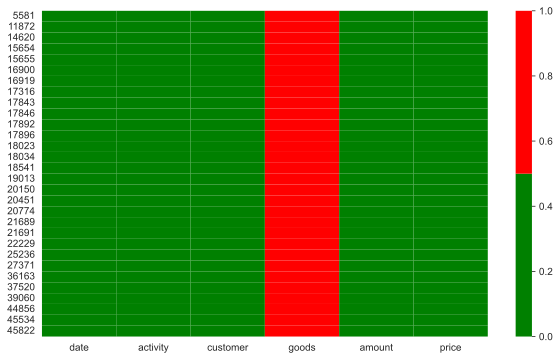

In [5]:
print('Количество пропусков:', df.isnull().any(axis=1).sum())
colors = ['g', 'r']
sns.heatmap(df.isnull()[df.isnull().any(axis=1)], cmap=sns.color_palette(colors))

In [6]:
df[df.isnull().any(axis=1)]

,date,activity,customer,goods,amount,price
5581,15.11.2020 17:45,13583,1034,NaN,1,4295.0
11872,18.11.2020 18:45,13682,1966,NaN,1,4295.0
14620,19.04.2021 19:29,20331,2336,NaN,1,3995.0
15654,07.06.2020 17:46,3797,2464,NaN,1,1870.0
15655,07.06.2020 17:46,3797,2464,NaN,1,1785.0
16900,11.07.2020 13:40,4633,2605,NaN,1,2810.0
16919,30.03.2021 19:30,19423,2605,NaN,1,8740.0
17316,01.12.2020 15:56,14176,2666,NaN,1,2780.0
17843,16.08.2020 20:03,6871,2725,NaN,1,3145.0
17846,16.08.2020 20:04,6872,2725,NaN,1,3145.0


<AxesSubplot:>

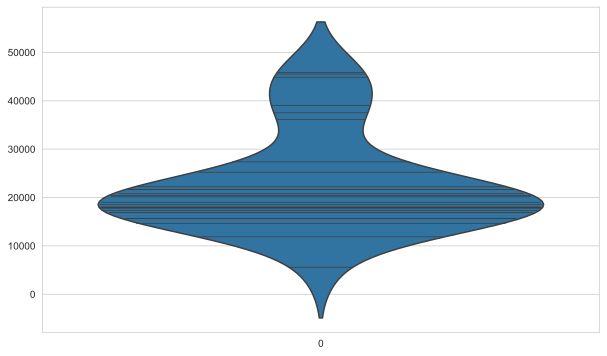

In [7]:
sns.violinplot(data=df[df.isnull().any(axis=1)].reset_index()['index'], inner="stick")

На основе анализа пропусков можно прийти к выводу, пропуски скорее всего ошибка человека который вносил данные(хотя такие данные редко вносит человек возможно это какие то удаленные товары)

Вывод: пропуски можно просто удалить

In [8]:
df.dropna(inplace=True)

In [9]:
df.goods = df.goods.astype('int')

### Дубликаты:

In [10]:
df[df.duplicated(keep=False)]

,date,activity,customer,goods,amount,price
130,19.06.2020 16:34,4078,22,4945,1,7070.0
131,19.06.2020 16:34,4078,22,4945,1,7070.0
133,03.07.2020 14:17,4416,22,4942,1,2830.0
134,03.07.2020 14:17,4416,22,4942,1,2830.0
163,12.08.2020 14:55,6332,22,4843,1,1495.0
...,...,...,...,...,...,...
48210,05.07.2021 20:03,25276,11010,5343,1,3490.0
48253,06.07.2021 11:30,25360,11031,244,1,1370.0
48258,06.07.2021 11:30,25360,11031,244,1,1370.0
48286,06.07.2021 14:54,25393,11046,4671,1,17490.0


количество дубликатов: 1127


<AxesSubplot:>

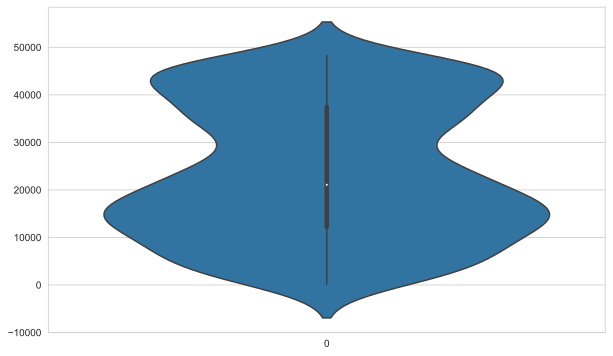

In [11]:
print('количество дубликатов:', df[df.duplicated(keep='first')].reset_index()['index'].size)
sns.violinplot(data=df[df.duplicated(keep='first')].reset_index()['index'])

In [12]:
df['amount'].unique()

array([1])

In [13]:
df

,date,activity,customer,goods,amount,price
0,03.05.2020 21:43,954,1,2874,1,8150.0
1,20.11.2020 20:46,13796,1,3586,1,3930.0
2,08.12.2020 16:28,14431,1,4942,1,2860.0
3,03.05.2020 21:15,951,2,2812,1,4895.0
4,20.05.2020 16:46,3352,2,5025,1,840.0
...,...,...,...,...,...,...
48298,06.07.2021 15:00,25398,11049,1211,1,20500.0
48299,06.07.2021 15:13,25399,11049,3034,1,21950.0
48300,06.07.2021 15:02,25412,11050,443,1,1490.0
48301,06.07.2021 15:02,25412,11050,2789,1,9450.0


In [14]:
df.groupby(df.columns.tolist ()).size()

date              activity  customer  goods  amount  price  
01.01.2021 15:31  15302     7007      2021   1       7020.0     1
                                      2280   1       9970.0     1
                                      5425   1       49450.0    1
01.01.2021 15:32  15303     5216      3709   1       2440.0     1
01.01.2021 21:28  15304     1581      3401   1       17000.0    1
                                                               ..
31.12.2020 18:08  15299     1979      538    1       5475.0     1
31.12.2020 18:26  15300     996       1793   1       33400.0    1
31.12.2020 19:21  15301     1821      2590   1       34500.0    1
                                      2769   1       11450.0    1
                                      2783   1       4300.0     1
Length: 47146, dtype: int64

Кажется что дубликатов совсем не много, но настараживает то, что amount имеет только одно значени: 1. Поэтому скорее всего дубликаты скорее всего покупка нескольких товаров одного типа.

Вывод: удаляем дубликаты увеличива показатель amount.

In [15]:
tmp = copy.deepcopy(df.groupby(df.columns.tolist(), as_index= False ).size()['size'])
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop= True, inplace=True)
df['amount'] = tmp

In [16]:
df['amount'].unique()

array([ 1,  2,  3,  6, 12,  4,  5,  9,  7], dtype=int64)

### Дополнительное преобразование типов

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47146 entries, 0 to 47145
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      47146 non-null  object 
 1   activity  47146 non-null  int64  
 2   customer  47146 non-null  int64  
 3   goods     47146 non-null  int32  
 4   amount    47146 non-null  int64  
 5   price     47146 non-null  float64
dtypes: float64(1), int32(1), int64(3), object(1)
memory usage: 2.0+ MB


In [18]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')

In [19]:
df.price.apply(lambda x: x * 10 % 1).unique()

array([0. , 0.9, 0.8, 0.5, 0.7, 0.3, 0.8, 0.4, 0.7, 0.9, 0.3, 0.6, 0.1,
       0.6, 0.4, 0.2, 0.6, 0.3, 0.4, 0.2, 0.1, 0.2, 0.4, 0.6, 0.7, 0.3,
       0.2, 0.1, 0.8, 0.8, 0.8, 0.2, 0.6, 0.7, 0.9, 0.3, 0.2, 0.2, 0.6,
       0.4, 0.7, 0.7, 0.1, 0.6, 0.3, 0.3, 0.2, 0.1, 0.2, 0.1, 0.4, 0.9,
       0.4, 0.3, 0.9, 0.9, 0.8, 0.9, 0.9, 0.8, 0.6, 0.8, 0.7])

Преобразование price не требуется поскольку оно действительно не целое.

### 4. EDA 
 
**Описательная статистика, поиск взаимосвязей**

In [20]:
def profile_data(df, dtyps='num'):
    types = dict(df.dtypes)
    for col in df.columns:
        if types[col] in (np.dtype('int64'), np.dtype('float64')) and dtyps == 'num':
            fig, ax = plt.subplots(2, 1)
            ax[0].hist(df[col])
            ax[0].set_title('histogram')
            df[col].plot.kde( ax=ax[1], title='KDE Plot')
            fig.suptitle(col)
            fig.tight_layout()
        elif len(set(df[col])) < 7 and dtyps == 'object':
            pass
#             fig, ax = plt.subplots();
#             data = df.groupby(col)['customerID'].count()
#             data = data.apply(lambda x: x / data.sum())
#             data = data.T.to_dict()
#             labels = list(data.keys())
#             vlues = []
#             for k in labels:
#                 vlues.append(data[k])
#             ax.pie(vlues, labels=labels,  autopct='%.0f%%')
#             fig.suptitle(col)
#             fig.tight_layout();

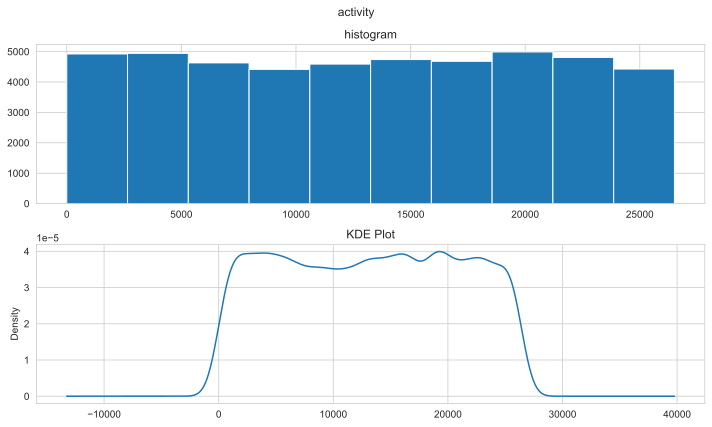

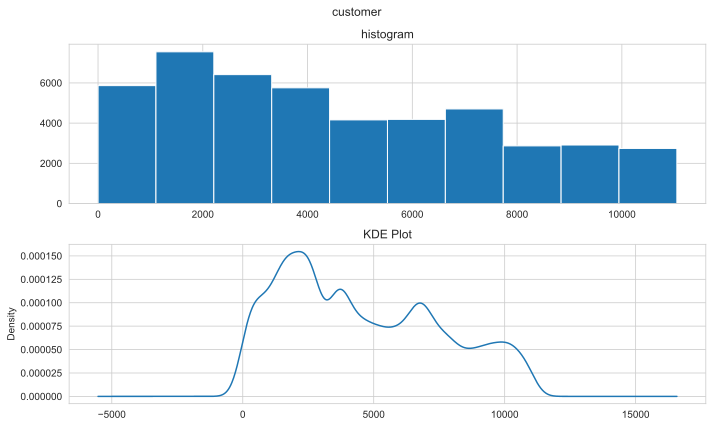

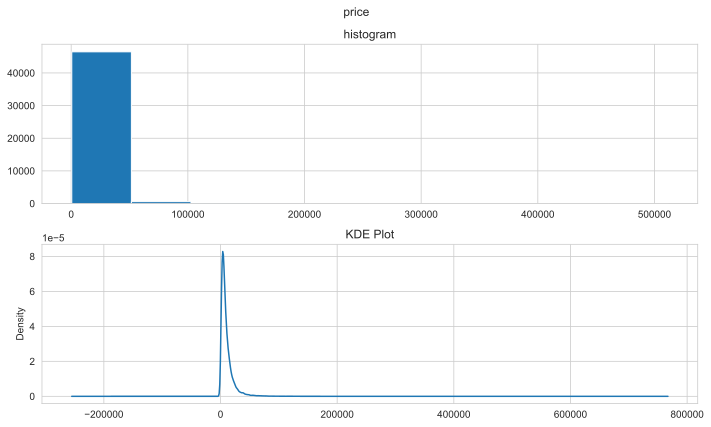

In [21]:
#Ваш код

#График распределения плотности

profile_data(df.drop(columns=['amount']))

<AxesSubplot:>

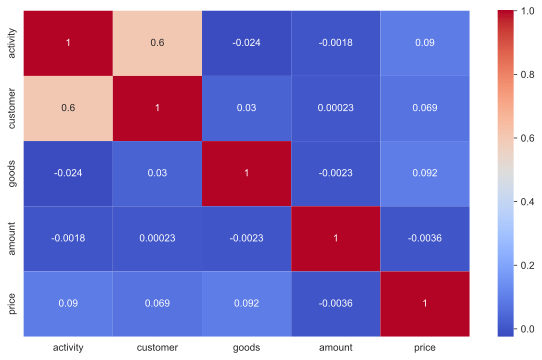

In [22]:
sns.heatmap(df.drop(columns=['date']).corr(), annot = True, cmap="coolwarm")

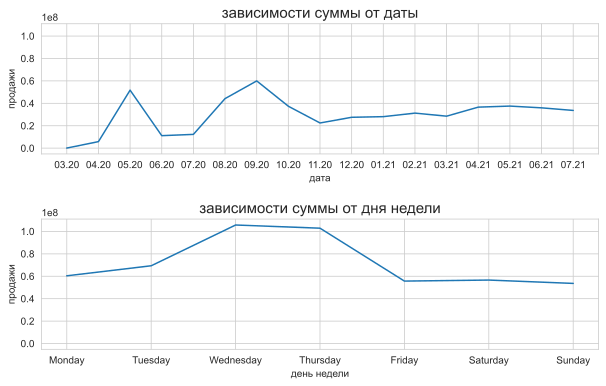

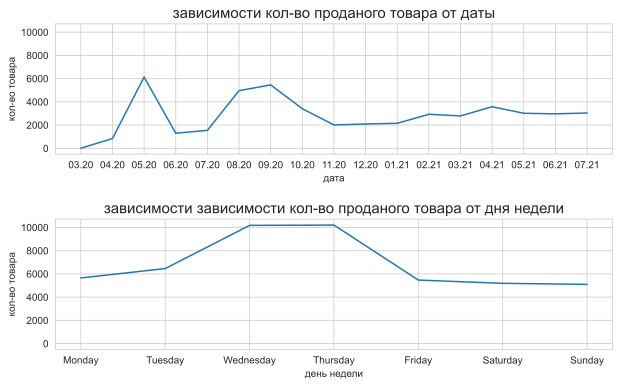

In [23]:

#График зависимости даты от суммы продаж или количество проданных товаров
#наверное все таки зависимости суммы от даты или количества от даты
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
fig.subplots_adjust(hspace=0.5)



df1 = copy.deepcopy(df)
df1['year'] = df1['date'].dt.year
df1['month'] = df1['date'].dt.month
df1['day_of_week'] = df1['date'].dt.weekday
df1['day_of_week_name'] = df1['day_of_week'] .map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
df1['date'] = df1['date'].dt.month.astype(str).apply(lambda x: f"0{x}"if len(x) < 2 else x) + '.' + df1['date'].dt.year.apply(lambda x: x % 100).astype(str)



sql_querty = """SELECT 
                    date,
                    SUM(price * amount) as sm
                FROM df1 
                GROUP BY date
                ORDER BY year, month """
sum_depend1 = sqldf(sql_querty)


ax1.plot(sum_depend1["date"], sum_depend1["sm"])
ax1.set_title("зависимости суммы от даты", fontsize=15) 
ax1.set_xlabel("дата", fontsize=10)   
ax1.set_ylabel("продажи", fontsize=10)






sql_querty = """SELECT 
                    day_of_week_name,
                    SUM(price * amount) as sm
                FROM df1 
                GROUP BY day_of_week_name
                ORDER BY day_of_week """
sum_depend2 = sqldf(sql_querty)

ax2.plot(sum_depend2["day_of_week_name"], sum_depend2["sm"])
ax2.set_title("зависимости суммы от дня недели", fontsize=15) 
ax2.set_xlabel("день недели", fontsize=10)   
ax2.set_ylabel("продажи", fontsize=10)





fig2, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
fig2.subplots_adjust(hspace=0.5)




sql_querty = """SELECT 
                    date,
                    SUM(amount) as am
                FROM df1 
                GROUP BY date
                ORDER BY year, month """
count_depend1 = sqldf(sql_querty)


ax1.plot(count_depend1["date"], count_depend1["am"])
ax1.set_title("зависимости кол-во проданого товара от даты", fontsize=15) 
ax1.set_xlabel("дата", fontsize=10)   
ax1.set_ylabel("кол-во товара", fontsize=10)




sql_querty = """SELECT 
                    day_of_week_name,
                    SUM(amount) as am
                FROM df1
                GROUP BY day_of_week_name
                ORDER BY day_of_week"""
count_depend2 = sqldf(sql_querty)


ax2.plot(count_depend2["day_of_week_name"], count_depend2["am"])
ax2.set_title("зависимости зависимости кол-во проданого товара от дня недели", fontsize=15) 
ax2.set_xlabel("день недели", fontsize=10)   
ax2.set_ylabel("кол-во товара", fontsize=10)


# count_depend = df.groupby("date")["amount"].agg(amount="sum").rename(columns={"amount": "amount sells per day"})
# count_depend.sort_values("amount sells per day", inplace=True)


# fig, ax = plt.subplots()
# ax.plot(spread["sells"], spread["goods"])
# ax.set_title("График распределения плотности", fontsize=25) 
# ax.set_xlabel("кол-во проданого товара", fontsize=15)   
# ax.set_ylabel("кол-во товаров проданных в даном количестве", fontsize=15)
# ax.set_xlim(0, 200) 
# ax.set_ylim(0, 150)
# fig.show()







fig.show()
fig2.show()

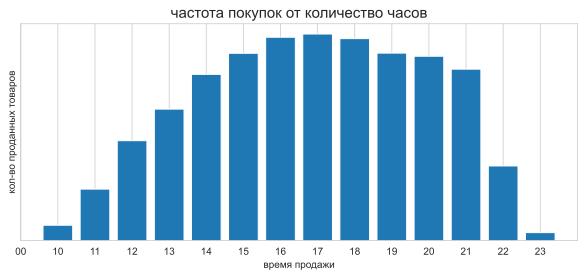

In [24]:

# Стобчатая диаграмма частоты покупок от количество часов
#наверное не от количества часов, а распределение количество покупок
fig, ax = plt.subplots(figsize=(10, 4))


sql_querty = """SELECT strftime('%H', date) AS hour ,
                SUM(amount) as am
                FROM df
                GROUP BY hour
                ORDER BY hour"""
amount_hour = sqldf(sql_querty)


# amount_hour = df.groupby(df["date"].dt.hour)["amount"].sum()     


ax.bar(amount_hour['hour'], amount_hour['am'])
# ax.set_xticks(['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'])
ax.set_title("частота покупок от количество часов", fontsize=15) 
ax.set_xlabel("время продажи", fontsize=10)   
ax.set_ylabel("кол-во проданных товаров", fontsize=10)
ax.set_xlim(0, 15)
ax.set_yticks([])
fig.show()



# print(amount_hour)


ТОВАРЫ УЧАСТВУЮЩИЕ В ПЕРВОМ И ВТОРОМ ГРАФИКЕ: {5064, 4944, 4757, 5019, 3487}


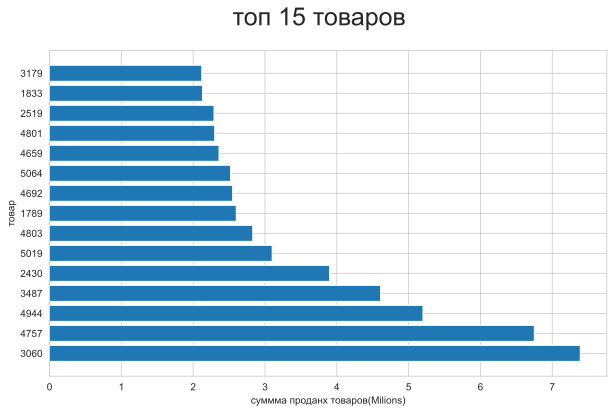

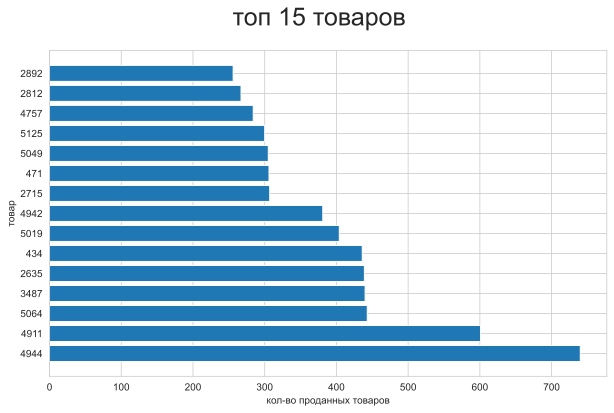

In [25]:


# Показать товары  максимальной выручкой за все время или популярные товары


fig1, ax1 = plt.subplots()
# fig.subplots_adjust(hspace=0.5)
fig1.suptitle("топ 15 товаров", fontsize=25)
# fig.set_figheight(15)
# fig.set_figwidth(14)


sql_querty = """SELECT
                    goods,
                    SUM(price * amount) as sm
                FROM df 
                GROUP BY goods
                ORDER BY sm desc
                LIMIT 15"""
max_money = sqldf(sql_querty)

max_money['sm'] = max_money['sm'].apply(lambda x: round(x / 1000000, 2))

ax1.barh(max_money['goods'].astype(str), max_money['sm'])
# ax1.set_title("", fontsize=15) 
ax1.set_xlabel("суммма проданх товаров(Milions)", fontsize=10)   
ax1.set_ylabel("товар", fontsize=10)
# ax1.set_yticks(max_money['goods'].astype(str))


fig2, ax2 = plt.subplots()
fig2.suptitle("топ 15 товаров", fontsize=25)


sql_querty = """SELECT 
                    goods,
                    SUM(amount) as am
                FROM df 
                GROUP BY goods
                ORDER BY am desc
                LIMIT 15"""
goods_sells = sqldf(sql_querty)


# goods_sells = df.groupby("goods")["amount"].agg(amount="sum").rename(columns={"amount": "amount sells per goods"})
# goods_sells.sort_values("amount sells per goods", inplace=True)


ax2.barh(goods_sells['goods'].astype(str), goods_sells['am'])
# ax.set_title("", fontsize=15) 
ax2.set_xlabel("кол-во проданных товаров", fontsize=10)   
ax2.set_ylabel("товар", fontsize=10)
# ax2.set_yticks(goods_sells['goods'].astype(str))



fig1.show()
fig2.show()
print( 'ТОВАРЫ УЧАСТВУЮЩИЕ В ПЕРВОМ И ВТОРОМ ГРАФИКЕ:', set(max_money['goods']) & set(goods_sells['goods']))
# print(max_money)
# print(goods_sells)


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47146 entries, 0 to 47145
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      47146 non-null  datetime64[ns]
 1   activity  47146 non-null  int64         
 2   customer  47146 non-null  int64         
 3   goods     47146 non-null  int32         
 4   amount    47146 non-null  int64         
 5   price     47146 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3)
memory usage: 2.0 MB


### 5.	Выполнить проверку гипотез о данных

5.1 Зависит ли частота покупок от месяца?

In [27]:
#Ваш код

In [28]:
sql_querty = """SELECT 
                    strftime('%m', date) as month,
                    strftime('%Y', date)  as year,
                    sum(amount) as volume
                FROM df
                GROUP BY year, month"""


customer_count = sqldf(sql_querty)
customer_count['volume'].corr(customer_count['month'].astype(int))

0.18993077856886773

это уже весьма не плохо Но что бы получить хоть какие нибудь результатаы нам нужно иметь хотя бы даные на 2-4 года.
Так что зависимоть есть с высокой вероятностью(видны резкие подьемы графика в августе и в сенетебре что говорит о том что магазин может быть канцтовары или что то такое) но определить эту зависимоть с приемлемой точность невозмодно.

 5.2 Больше лучших клиентов, чем потерянных клиентов?
 
 Т.е. выяснить больше ли клиентов, которые покупали совсем недавно, чаще всего и тратят больше всего, 
 чем клиентов, у которых последняя покупка была давно, и покупали мало и тратили мало.

Нет четкого определения хорошего\плохого клиента. Недостает конкретных чисел: потратил сk и покупал в течении поледних n месяцов m товаров. Тогда определим эти числа сами. Например хороший клиент - клиент который купил за три месяца на сумму большую чем 80% (num1)потратили за первые три месяца. Плохой же клиент - клиент который потратил меньше чем 85%(num2) за первые три месяц или меньше чем 70%(num3) но купил товара не более чем 60% (num4)в первые три месяца. Тогда нас интересует 1 статика кол-ва плохих\хороших клиентов по месяцам 2 динамика изменения кол-ва хороших\плохих клиентов 3 динамика указывающая что происходит: удержание хороших клиентов или нескончаемый приток-отток клиентов.

In [29]:
#Ваш код
sql_querty = """SELECT 
                    COUNT(customer) as cnt
                FROM(SELECT distinct
                            customer
                        FROM df
                        WHERE strftime('%m', date) < '06' and strftime('%Y', date) = '2020') tm"""


customer_count = int(sqldf(sql_querty)['cnt'][0])


sql_querty = f"""SELECT 
                     MAX(sm2) as maxsm
                FROM        (SELECT customer,
                                    SUM(sm) as sm2
                             FROM(  SELECT
                                        customer,
                                        sum(price * amount) as sm
                                    FROM df
                                    WHERE strftime('%m', date) < '06' and strftime('%Y', date) = '2020'
                                    GROUP BY customer, strftime('%m', date) )tm1
                            GROUP BY customer
                            ORDER BY sm2
                            LIMIT {int(customer_count * 80 / 100)}) tm2 """
num1 = int(sqldf(sql_querty)['maxsm'][0])
num1

28882

In [30]:
sql_querty = f"""SELECT 
                    MIN(sm2) as maxsm
                FROM        (SELECT customer,
                                    SUM(sm) as sm2
                             FROM(  SELECT
                                        customer,
                                        sum(price * amount) as sm
                                    FROM df
                                    WHERE strftime('%m', date) < '06' and strftime('%Y', date) = '2020'
                                    GROUP BY customer, strftime('%m', date) )tm1
                            GROUP BY customer
                            ORDER BY sm2 DESC
                            LIMIT {int(customer_count * 85 / 100)}) tm2 """
num2 = int(sqldf(sql_querty)['maxsm'][0])
num2

3430

In [31]:
sql_querty = f"""SELECT 
                    MIN(sm) as maxsm
                FROM        (SELECT customer,
                                    SUM(sm) as sm
                             FROM(  SELECT
                                        customer,
                                        sum(price * amount) as sm
                                    FROM df
                                    WHERE strftime('%m', date) < '06' and strftime('%Y', date) = '2020'
                                    GROUP BY customer, strftime('%m', date) )tm1
                            GROUP BY customer
                            ORDER BY sm DESC
                            LIMIT {int(customer_count * 70 / 100)}) tm2 """
num3 = int(sqldf(sql_querty)['maxsm'][0])
num3

6350

In [32]:
sql_querty = f"""SELECT 
                    MIN(am) as maxam
                FROM        (SELECT customer,
                                    SUM(am) as am
                             FROM(  SELECT
                                        customer,
                                        sum(amount) as am
                                    FROM df
                                    WHERE strftime('%m', date) < '06' and strftime('%Y', date) = '2020'
                                    GROUP BY customer, strftime('%m', date) )tm1
                            GROUP BY customer
                            ORDER BY am DESC
                            LIMIT {int(customer_count * 60 / 100)}) tm2 """
num4 = int(sqldf(sql_querty)['maxam'][0])
num4

1

In [33]:
sql_querty = f"""  SELECT distinct
                                         
                                            strftime('%m', date)
                                        FROM df
                                        WHERE '2020-03' <= date AND date <= '2020-05-31'
                                        GROUP BY customer, strftime('%m', date) 
                """


sqldf(sql_querty)

,"strftime('%m', date)"
0,05
1,04
2,03


Получим списки Хороших покупателей за каждй месяц тем самым выполнив условие 1: получить статику покупателей по месецам

In [34]:
sql_querty = f"""SELECT distinct
                    strftime('%m', date) as month,
                    strftime('%Y', date) as year
                FROM df 
                ORDER BY year, month"""
dates = sqldf(sql_querty)


dict_good_customers = {}


def prev1_month(month, year):
    if int(month) < 2:
        month = int(month) + 11
        year = int(year) - 1
    else:
        month = int(month) - 1
        year = int(year)
    if month < 10:
        month = f'0{month}'
    month = str(month)
    year = str(year)
    return {'month': month, 'year':year }


def prev2_month(month, year):
    p = prev1_month(int(month), int(year))
    month = int(p['month'])
    year = int(p['year'])
    return prev1_month(int(month), int(year))

for month, year in zip(dates['month'].drop([0, 1]), dates['year'].drop([0, 1])):    #убираем первые две строчки тк для них нет 3 преведущих месяцов для анализа
    print(prev2_month(month, year), "-" ,{'month': month, 'year':year })
    sql_querty = f"""SELECT 
                        customer as good_customer
                    FROM        (SELECT customer,
                                        SUM(sm) as sm2
                                 FROM(  SELECT
                                            customer,
                                            sum(price * amount) as sm
                                        FROM df
                                        WHERE '{prev2_month(month, year)['year']}-{prev2_month(month, year)['month']}-00' <= date AND date <= '{year}-{month}-31'
                                        GROUP BY customer, strftime('%m', date) )tm1
                                GROUP BY customer) tm2 
                    WHERE {num1} < sm2
                """
#     print(sql_querty)
    dict_good_customers.update({f'{month}.{int(year) % 100}':sqldf(sql_querty)})
    print(dict_good_customers[f'{month}.{int(year) % 100}'])

{'month': '03', 'year': '2020'} - {'month': '05', 'year': '2020'}
     good_customer
0                4
1                9
2               11
3               22
4               25
..             ...
529           2777
530           2778
531           2780
532           2781
533           4526

[534 rows x 1 columns]
{'month': '04', 'year': '2020'} - {'month': '06', 'year': '2020'}
     good_customer
0                4
1                9
2               11
3               22
4               25
..             ...
627           2777
628           2778
629           2780
630           2781
631           2782

[632 rows x 1 columns]
{'month': '05', 'year': '2020'} - {'month': '07', 'year': '2020'}
     good_customer
0                4
1                9
2               11
3               22
4               24
..             ...
677           2780
678           2781
679           2782
680           6587
681           6934

[682 rows x 1 columns]
{'month': '06', 'year': '2020'} - {'month': '0

Получим списки Плохих покупателей за каждй месяц тем самым выполнив условие 1: получить статику покупателей по месецам

In [35]:
dict_bad_customers = {}
for month, year in zip(dates['month'].drop([0, 1]), dates['year'].drop([0, 1])):    #убираем первые две строчки тк для них нет 3 преведущих месяцов для анализа
    print(prev2_month(month, year), "-" ,{'month': month, 'year':year })
    sql_querty = f"""SELECT 
                        customer as bad_customer
                    FROM       (SELECT customer,
                                        SUM(sm) as sm2,
                                        SUM(am) as am2
                                 FROM(  SELECT
                                            customer,
                                            SUM(price * amount) as sm,
                                            SUM(amount) as am
                                        FROM df
                                        WHERE '{prev2_month(month, year)['year']}-{prev2_month(month, year)['month']}-00' <= date AND date <= '{year}-{month}-31'
                                        GROUP BY customer, strftime('%m', date) ) tm1
                                GROUP BY customer) tm2
                    WHERE {num2} > sm2 or ({num3} > sm2 and am2 > {num4})
                """
    dict_bad_customers.update({f'{month}.{int(year) % 100}':sqldf(sql_querty)})
    print(dict_bad_customers[f'{month}.{int(year) % 100}'])

{'month': '03', 'year': '2020'} - {'month': '05', 'year': '2020'}
     bad_customer
0               2
1               5
2               6
3              12
4              16
..            ...
486          2759
487          2762
488          2764
489          2765
490          2771

[491 rows x 1 columns]
{'month': '04', 'year': '2020'} - {'month': '06', 'year': '2020'}
     bad_customer
0               2
1               5
2               6
3              12
4              16
..            ...
468          2762
469          2764
470          2765
471          2771
472          2783

[473 rows x 1 columns]
{'month': '05', 'year': '2020'} - {'month': '07', 'year': '2020'}
     bad_customer
0               2
1               5
2               6
3              12
4              16
..            ...
403          2764
404          2765
405          2771
406          2783
407          3794

[408 rows x 1 columns]
{'month': '06', 'year': '2020'} - {'month': '08', 'year': '2020'}
     bad_custome

Теперь можно выполнит пункт 2 и помотреть на динамику кол-ва хороших\плохих клиентов

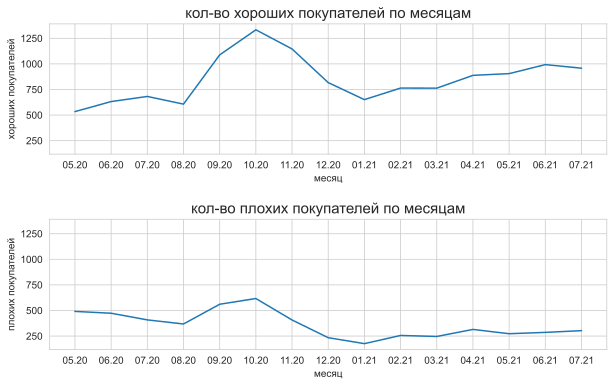

In [36]:
fig1, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
fig1.subplots_adjust(hspace=0.5)
to_print_x = []
to_print_y = []
for i in dict_good_customers.keys():
    to_print_x += [i]
    to_print_y += [dict_good_customers[i].count()]
ax1.plot(to_print_x, to_print_y)
ax1.set_title("кол-во хороших покупателей по месяцам", fontsize=15) 
ax1.set_xlabel("месяц", fontsize=10)   
ax1.set_ylabel("хороших покупателей", fontsize=10)
to_print_x = []
to_print_y = []
for i in dict_bad_customers.keys():
    to_print_x += [i]
    to_print_y += [dict_bad_customers[i].count()]
ax2.plot(to_print_x, to_print_y)
ax2.set_title("кол-во плохих покупателей по месяцам", fontsize=15) 
ax2.set_xlabel("месяц", fontsize=10)   
ax2.set_ylabel("плохих покупателей", fontsize=10)
fig1.show()

А теперь отследим такие показатели: 1 сколько хороших клиентов перестали быть хорошими в этом месяце 2 сколько появилось новых хороших клиентов 3 сколько плохих клиентов перестали покупать вовсе (те стали утереными) 4 сколько ранее нормальных клиенов стали плохими(тут не стоит учитывать тех клиентов которые являются новыми, а лишь тех кто уже был клиентом, но стал разачарован в магазине и стал покупать меньше).

Text(0, 0.5, 'хороших покупателей')

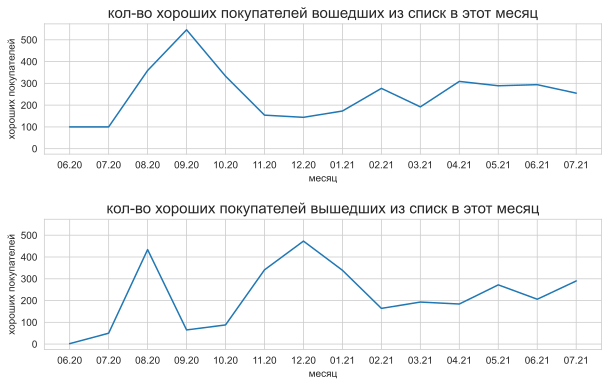

In [37]:
fig1, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
fig1.subplots_adjust(hspace=0.5)



date1 = []
customers = []
for i in dict_good_customers.keys():
    date1 += [i]
    customers += [set(dict_good_customers[i]['good_customer'])]
    
    

good_customers_joind = {}
good_customers_escaped = {}
for i in range(1, len(date1)):
    good_customers_joind.update({date1[i]: customers[i] - customers[i-1]})
    good_customers_escaped.update({date1[i]: customers[i - 1] - customers[i]})


    
to_print_x = []
to_print_y = []
for i in good_customers_joind.keys():
    to_print_x += [i]
    to_print_y += [len(good_customers_joind[i])]
ax1.plot(to_print_x, to_print_y)
ax1.set_title("кол-во хороших покупателей вошедших из списк в этот месяц", fontsize=15) 
ax1.set_xlabel("месяц", fontsize=10)   
ax1.set_ylabel("хороших покупателей", fontsize=10)




to_print_x = []
to_print_y = []
for i in good_customers_escaped.keys():
    to_print_x += [i]
    to_print_y += [len(good_customers_escaped[i])]
ax2.plot(to_print_x, to_print_y)
ax2.set_title("кол-во хороших покупателей вышедших из списк в этот месяц", fontsize=15) 
ax2.set_xlabel("месяц", fontsize=10)   
ax2.set_ylabel("хороших покупателей", fontsize=10)


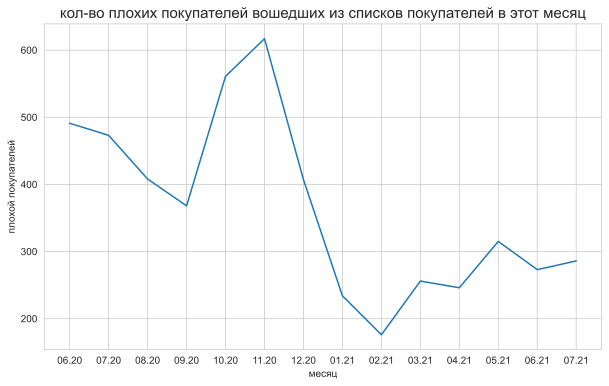

In [38]:
fig1, ax  = plt.subplots()



date1 = []
customers = []
for i in dict_bad_customers.keys():
    date1 += [i]
    customers += [set(dict_bad_customers[i]['bad_customer'])]
    
    

bad_customers_escaped = {}
for i in range(1, len(date1)):
    month, year = map(int, date1[i].split('.'))
    sql_querty = f"""SELECT distinct
                         customer
                     FROM df
                    WHERE '{year}-{month}-00' <= date AND date <= '{year}-{month}-31' """
    customers_now = set(sqldf(sql_querty)['customer'])
    bad_customers_escaped.update({date1[i]: customers[i - 1] - customers_now})



to_print_x = []
to_print_y = []
for i in bad_customers_escaped.keys():
    to_print_x += [i]
    to_print_y += [len(bad_customers_escaped[i])]
ax.plot(to_print_x, to_print_y)
ax.set_title("кол-во плохих покупателей вошедших из списков покупателей в этот месяц", fontsize=15) 
ax.set_xlabel("месяц", fontsize=10)   
ax.set_ylabel("плохой покупателей", fontsize=10)
fig.show()

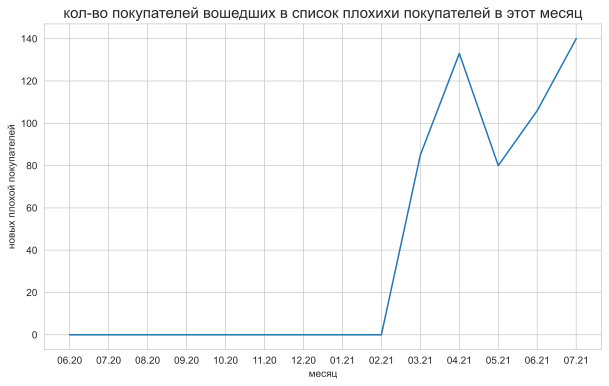

In [39]:
fig1, ax  = plt.subplots()



# сколько ранее нормальных клиенов стали плохими
# кто ранее был нормальным? тот кто раньше не был в списке плохихи клиентов но был клиентом ранее чем 3 месяца назад
# те мы исчем людей которые 1 что то покупали за три месяца до этого 2 тех кто не содержится в преведущем списке плохих клиентов


date1 = []
customers = []
for i in dict_bad_customers.keys():
    date1 += [i]
    customers += [set(dict_bad_customers[i]['bad_customer'])]
    
    

bad_customers_joind = {}
for i in range(1, len(date1)):
    month, year = map(int, date1[i].split('.'))
    sql_querty = f"""SELECT distinct
                         customer
                     FROM df
                    WHERE date < '{prev2_month(month, year)['year']}-{prev2_month(month, year)['month']}-00' """
    customers_now = set(sqldf(sql_querty)['customer'])
    bad_customers_joind.update({date1[i]: (customers[i] - customers[i - 1]) & customers_now})



to_print_x = []
to_print_y = []
for i in bad_customers_joind.keys():
    to_print_x += [i]
    to_print_y += [len(bad_customers_joind[i])]
ax.plot(to_print_x, to_print_y)
ax.set_title("кол-во покупателей вошедших в список плохихи покупателей в этот месяц", fontsize=15) 
ax.set_xlabel("месяц", fontsize=10)   
ax.set_ylabel("новых плохой покупателей", fontsize=10)
fig1.show()

### 6. Кластеризация клиентов по товарам

Для класторизации будем пользоватся методом k-mean. Для начала нужно представить данные в виде n-мерных точек

In [108]:
#Ваш код
df4 = copy.deepcopy(df[['date', 'goods', 'customer']])
df4['month'] = df4['date'].dt.month
df4['year'] = df4['date'].dt.year
goods = df4['goods'].unique()
customers = df4['customer'].unique()

        

points = {j:[0 for i in range(len(goods))] for j in customers}

for i in df4[['customer', 'goods']].iterrows():
    points[i[1]['customer']][np.where(goods == i[1]['goods'])[0][0]] += 1

for i in points.keys():
    points[i] = tuple(points[i])
    
#тествая выборка
    
test_keays = list(points.keys())[:len(points.keys()) // 10]
test_point = {}
for i in test_keays:
    test_point.update({i:points.pop(i)})
# f = list(points.keys())
# f = f[:10]
# for i in f:
#     print(points[i])

Теперь используя sklearn найдем центры кластеров.

In [109]:
def check_k(min_k, max_k, step):    # стоит делать так что бы проверялось 5-7 k за раз не больше
    inertia = []                                  # тк скорость програмы медленная
    for i in range(min_k, max_k, step):
        kmeans = MiniBatchKMeans(n_clusters=i, random_state=42) 
        kmeans.fit(tuple(points.values()))
        inertia += [np.sqrt(kmeans.inertia_)]
    print(inertia)
    paint(min_k, max_k, step, inertia)

def paint(min_k, max_k, step , inertia1):
    fig1, ax  = plt.subplots()
    ax.plot(range(min_k, max_k, step), inertia1)
    ax.set_xticks(range(min_k, max_k, step))
    ax.set_xlabel('k')
    ax.set_ylabel('сумма квадратов расстояний от точек до центров кластеров');
    fig1.show()

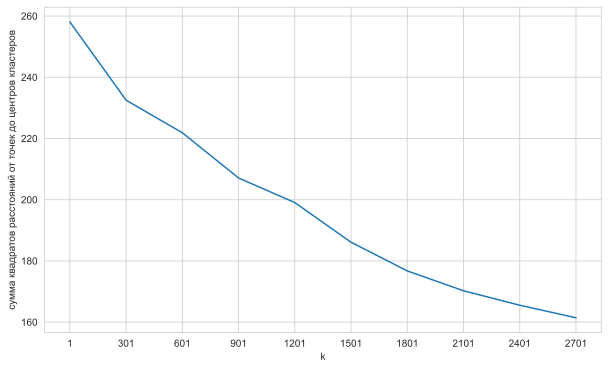

In [110]:
#check_k(min_k = 1, max_k = 3000, step = 300)
min_k = 1
max_k = 3000
step = 300
inertia = [258.0640235500702, 232.49719715382173, 221.8646557573883, 207.09047348267788, 199.04778536637608, 186.10220384402206, 176.73767734550398, 170.24504633947217, 165.5174321417109, 161.41862157285803]
paint(min_k, max_k, step , inertia)

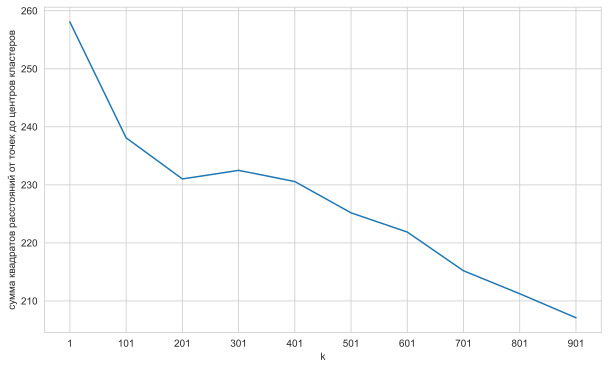

In [111]:
min_k = 1
max_k = 1000
step = 100
# check_k(min_k, max_k, step)
inertia = [258.0640235500702, 238.1028082379377, 231.0235509638399, 232.49719715382173, 230.56859703327663, 225.1740536260902, 221.8646557573883, 215.19147544884427, 211.23441328076234, 207.09047348267788]
paint(min_k, max_k, step , inertia)

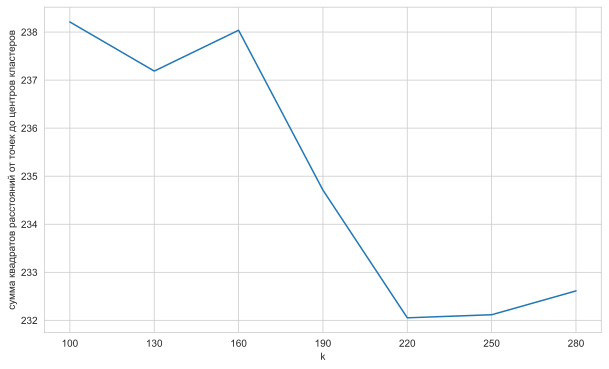

In [112]:
min_k = 100
max_k = 300
step = 30
# check_k(min_k, max_k, step)
inertia = [238.2100180627044, 237.18844614911967, 238.03821927916945, 234.71093911823598, 232.05331632988063, 232.11705887681595, 232.6135216747795]
paint(min_k, max_k, step , inertia)

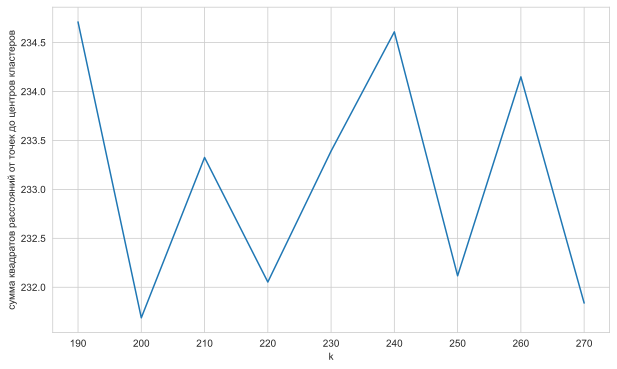

In [113]:
min_k = 190
max_k = 280
step = 10
# check_k(min_k, max_k, step)
inertia = [234.71093911823598, 231.687772458759, 233.32611940178384, 232.05331632988063, 233.39174934004964, 234.61010336260776, 232.11705887681595, 234.15012895267063, 231.83889126340011]
paint(min_k, max_k, step , inertia)

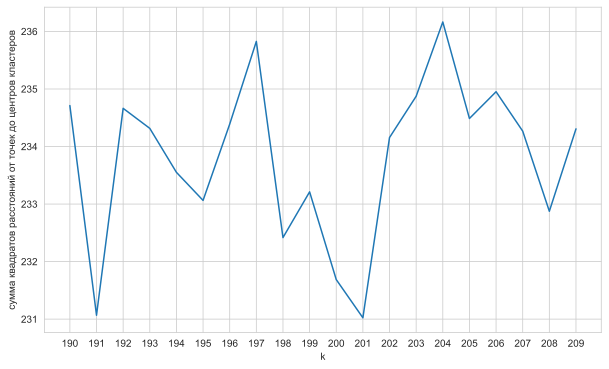

In [114]:
min_k = 190
max_k = 210
step = 1
# check_k(min_k, max_k, step)
inertia = [234.71093911823598, 231.06854177287448, 234.6635180300707, 234.31552468432716, 233.55155661800913, 233.06372872083656, 234.38911389573101, 235.82675058051862, 232.41768968168955, 233.21226075506357, 231.687772458759, 231.0235509638399, 234.1561910971029, 234.87378274886657, 236.1646118824407, 234.48763672330384, 234.95233543874693, 234.26733176699312, 232.8752536737436, 234.30632839003167]
paint(min_k, max_k, step , inertia)

In [115]:
kmeans = MiniBatchKMeans(n_clusters=191, random_state=42) 
kmeans.fit(list(points.values()))
centers =  kmeans.cluster_centers_
# customers_clasters = dict(zip(customers, kmeans.labels_))
# customers_clasters2 = dict(zip(customers, map(lambda x: dict(zip(goods, centers[x])), kmeans.labels_)))
# customers_clasters2

10989

In [ ]:
# for user in list(customers_clasters2.keys())[:100]:
#     user_data = customers_clasters2[user]
#     val = min(sorted(user_data.values())[-5:])
# #     print(sorted(user_data.values())[-5:])
#     print("user_id", 'item_id', 'importance')
#     for i in filter(lambda x: user_data[x] > val, user_data.keys()):
#         print(user , " " * (6 - len(str(user))), i , " " * (6 - len(str(i))), user_data[i] )

### 8.	Рекомендации

In [116]:
#Ваш код

df4 = copy.deepcopy(df[['date', 'goods', 'customer']])
df4['month'] = df4['date'].dt.month
df4['year'] = df4['date'].dt.year
goods = df4['goods'].unique()
customers = df4['customer'].unique()

        

points = {j:[0 for i in range(len(goods))] for j in customers}

for i in df4[['customer', 'goods']].iterrows():
    points[i[1]['customer']][np.where(goods == i[1]['goods'])[0][0]] += 1

for i in points.keys():
    points[i] = tuple(points[i])


In [117]:
kmeans = MiniBatchKMeans(n_clusters=191, random_state=42) 
kmeans.fit(list(points.values()))

MiniBatchKMeans(n_clusters=191, random_state=42)

Будем рекомендовать товар в зависимости от группы который принадлежит человек. Будем предлагать ниболее ходовой товар в данной группе.

In [118]:
def recomend(customer, n = 10):
    centers =  kmeans.cluster_centers_
    center = kmeans.predict([points[customer]])
    data = centers[center][0] # мы передаем в модель 2D array и возвращвет она 2D array состоящий из 1 элемента
    min1 = min(sorted(data, reverse=True)[:n + 1])
    max1 = max(sorted(data, reverse=True)[:n + 1])
    if max1 == 0.0: return None
    while max1 / min1 > 10 or min1 == 0.0:
        n -= 1
        min1 = min(sorted(data, reverse=True)[:n + 1])
        max1 = max(sorted(data, reverse=True)[:n + 1])
    center = list(map(lambda x: (x, int(round(0.51 * x / min1, 0))), data))
    recomended_goods = []
    for i in range(len(center)):
        if center[i][1] > 0:
            recomended_goods += [(center[i][0], goods[i])]
    recomended_goods.sort(key=lambda x: x[0])
    recomended_goods = list(map(lambda x: x[1], recomended_goods))
    return recomended_goods

recomend(customers[21])

[4975, 5302, 4945]

Или будем предлогать пользователю тот товар которой имеет наименьшее знаение относительно центроида (для каждого товара будем формировать % отношение отн. центроида) 

In [119]:
def recomend2(customer, n = 10):
    centers =  kmeans.cluster_centers_
    center = kmeans.predict([points[customer]])
    center_data = list(map(lambda x: round(x, 3), centers[center][0])) #срвзу округляем до 3 знаков после запятой
    data = []
    for i in range(len(center_data)):
        if center_data[i] > 0:
            data += [(points[customer][i] - center_data[i], i)]
    if not len(data): return None
#     print(data)
    recomended_goods = list(
        map(lambda x: goods[x[1]],
                            sorted(data, key=lambda x: x[0])[:n + 1]
           ))
    return recomended_goods

recomend2(customers[150])

[2699, 2927, 5367, 1789, 3583, 1015, 5030, 1833, 308, 2430, 2634]

In [105]:
set(df[df['customer'] == 150]['goods']) & set(recomend2(customers[150]))

{1789, 1833}

In [124]:
customers[150]

151

In [150]:
import random


def recomend(vector, n = 10):
    centers =  kmeans.cluster_centers_
    center = kmeans.predict([vector])
    data = centers[center][0] # мы передаем в модель 2D array и возвращвет она 2D array состоящий из 1 элемента
    min1 = min(sorted(data, reverse=True)[:n + 1])
    max1 = max(sorted(data, reverse=True)[:n + 1])
    if max1 == 0.0: return None
    while max1 / min1 > 10 or min1 == 0.0:
        n -= 1
        min1 = min(sorted(data, reverse=True)[:n + 1])
        max1 = max(sorted(data, reverse=True)[:n + 1])
    center = list(map(lambda x: (x, int(round(0.51 * x / min1, 0))), data))
    recomended_goods = []
    for i in range(len(center)):
        if center[i][1] > 0:
            recomended_goods += [(center[i][0], goods[i])]
    recomended_goods.sort(key=lambda x: x[0])
    recomended_goods = list(map(lambda x: x[1], recomended_goods))
    return recomended_goods


def recomend2(vector, n = 10):
    centers =  kmeans.cluster_centers_
    center = kmeans.predict([vector])
    center_data = list(map(lambda x: round(x, 3), centers[center][0])) #срвзу округляем до 3 знаков после запятой
    data = []
    for i in range(len(center_data)):
        if center_data[i] > 0:
            data += [(vector[i] - center_data[i], i)]
    if not len(data): return None
#     print(data)
    recomended_goods = list(
        map(lambda x: goods[x[1]],
                            sorted(data, key=lambda x: x[0])[:n + 1]
           ))
    return recomended_goods


results1 = []
results2 = []
for customer_id in test_point.keys():
    true_vector = test_point[customer_id] 
    test_vector = list(true_vector)
    changed = []
    rondom_index = random.randint(0, 5)
    for i in test_vector:
        if test_vector[i] > 0:
#             print('do')
            changed += [goods[i]]
            test_vector[i] = random.randint(0, test_vector[i])
            rondom_index += 1
        rondom_index += random.randint(0, 5)
#     test_vector = tuple(test_vector)
#     print(test_vector)
    result1 = recomend(test_vector)
    result2 = recomend2(test_vector)
#     print("changed", changed)
#     print("recomend2", result2)
    if len(changed):
#         print(len(changed))
        if len(result1):
            results1 += [len(set(changed) & set(result1)) / len(set(result1))]
        if len(result2):
            results2 += [len(set(changed) & set(result2)) / len(set(result2))]
#             for i in set(changed) & set(result2):
#                 print(result2.index(i))
print('alg 1', sum(results1)/len(results1))
print('alg 2', sum(results2)/len(results2))

do
do
do
do
4
do
do
do
do
4
do
1
do
1
do
1
do
1
do
1
do
do
do
do
4
do
1
do
1
do
1
do
1
do
1
do
1
do
1
do
do
do
3
do
1
do
do
2
do
1
do
do
do
do
4
do
do
do
3
do
1
do
do
2
do
do
2
do
1
do
do
2
do
1
do
1
do
1
do
1
do
1
do
do
2
do
1
do
1
do
do
do
do
do
5
do
1
alg 1 0.19444444444444445
alg 2 0.020202020202020207


In [155]:
len(df['customer'].unique())

10989

## Вывод